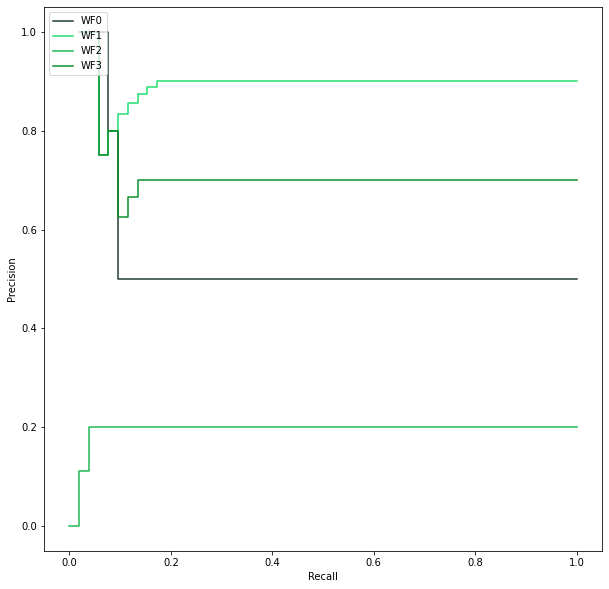

In [41]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import requests
import urllib

from sklearn.metrics import PrecisionRecallDisplay

colors = [
    "#1F3F2A", 
    "#1FDF6F", 
    "#1DB954", 
    "#098E2A",
]

sb.set_palette(sb.color_palette(colors))

QRELS_FILE = "data/relevant.txt"


# Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(QRELS_FILE).readlines()))

relevant_list_attribute = "name"

# Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(QRELS_FILE).readlines()))
# Get query results from Solr instance
results = requests.get(QUERY_URL).json()['response']['docs']

systems = [
    "name lyrics artists.name artists.genres albums.name",
    "name^5 lyrics^3 artists.name^1 artists.genres albums.name^3",
    "name^1 lyrics^3 artists.name artists.genres^5 albums.name",
    "name^3 lyrics^5 artists.name artists.genres albums.name"
]

_, ax = plt.subplots(figsize=(10, 10))

interpolated_precision = []
interpolated_recall = []

for i, system in enumerate(systems):
    # Get query results from Solr instance
    qf = urllib.parse.quote(system)
    query_url = f"http://localhost:8983/solr/music/select?defType=edismax&df=name%2Clyrics%2Cartists.name%2Cartists.genre&fl=name&indent=true&q.op=OR&q=love&qf={qf}&wt=json"

    results = requests.get(query_url).json()['response']['docs']

    precision = [
        len([
            doc
            for doc in results[:idx]
            if doc[relevant_list_attribute] in relevant
        ]) / idx
        for idx, _ in enumerate(results, start=1)
    ]

    recall = [
        len([
            doc for doc in results[:idx]
            if doc[relevant_list_attribute] in relevant
        ]) / len(relevant)
        for idx, _ in enumerate(results, start=1)
    ]

    precision_recall_match = dict(zip(recall, precision))

    # Extend recall to include traditional steps for a better curve (0.1, 0.2 ...)
    recall.extend([step for step in np.arange(0.1, 1.1, 0.1) if step not in recall])
    recall = sorted(set(recall))

    # Extend matching dict to include these new intermediate steps
    for idx, step in enumerate(recall):
        if step not in precision_recall_match:
            if recall[idx - 1] in precision_recall_match:
                precision_recall_match[step] = precision_recall_match[recall[idx - 1]]

            else:
                precision_recall_match[step] = precision_recall_match[recall[idx + 1]]

    display = PrecisionRecallDisplay([precision_recall_match[r] for r in recall], recall)
    display.plot(ax=ax, name=f"WF{i}")

ax.legend(loc="upper left")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

plt.savefig("out/precision_recall.png")